# INTRODUCCIÓN 

Para el presente proyecto, supondremos que trabajamos para la tienda online "Ice" que vende videojuegos por todo el mundo. Contamos con una base de datos donde podemos encontrar las reseñas de usuarios y críticos expertos de la industria, los géneros, las plataformas (consolas) y los datos históricos sobre las ventas de videojuegos.

Nuestro objetivo será identificar patrones que determinen si un juego tendrá éxito o no. Esto permitirá a la empresa detectar proyectos prometedores y planificar campañas publicitarias, lanzamientos en las plataformas con mayor potencial y un ciclo de vida óptimo.


En este cuaderno de Jupyter realizaremos el preprocesamiento de datos, 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats as st

# Paso 1. Abre el archivo de datos y estudia la información general 

In [2]:
df_games= pd.read_csv("/datasets/games.csv")

In [3]:
df_games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# Paso 2. Prepara los datos

Convertimos los nombres de las columnas en minúsculas para facilitar el trabajo con nombres.

In [4]:
df_games.columns= df_games.columns.str.lower()

In [5]:
df_games.head()
df_games.tail()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


In [6]:
df_games.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

In [7]:
df_games["year_date_fixed"] = pd.to_datetime(df_games["year_of_release"], format="%Y")

Analizamos el tipo de datos que encontramos en cada columna y realizamos una rápida exploración de los valores en aquellas columnas que transformaremos al tipo de datos deseados.

Aquí generamos una nueva columna con la información en el tipo de datos "datetime" para poder trabajar con ellos de forma más cómoda que si fueran tipo float.

In [8]:
df_games["user_score"].value_counts(dropna=False).sort_index()

0         1
0.2       2
0.3       2
0.5       2
0.6       2
       ... 
9.5       6
9.6       2
9.7       1
tbd    2424
NaN    6701
Name: user_score, Length: 97, dtype: int64

In [9]:
df_games["critic_score"].value_counts(dropna=False).sort_index()

13.0       1
17.0       1
19.0       6
20.0       3
21.0       1
        ... 
95.0      16
96.0      18
97.0      11
98.0       4
NaN     8578
Name: critic_score, Length: 83, dtype: int64

In [10]:
df_games["user_score_fixed"]=np.where(
    df_games["user_score"]=="tbd",
    -1,
    df_games["user_score"]
)

df_games["user_score_fixed"] = df_games["user_score_fixed"].astype("float")

df_games[["critic_score", "user_score_fixed" ]].describe()

,critic_score,user_score_fixed
count,8137.000000,10014.000000
mean,68.967679,5.158288
std,13.938165,3.717310
min,13.000000,-1.000000
25%,60.000000,2.400000
50%,71.000000,6.900000
75%,79.000000,8.000000
max,98.000000,9.700000


En este caso generamos una nueva columna para los datos de user_score, cambiamos la cadena "tbd" por "-1" para que no haya problema con otro tipo de calificaciones, ya que no hay ninguna calificación negativa. Generamos una nueva columna para que nuestra columna original esté intacta, por si necesitamos hacer algún cambio más adelante.

In [11]:
df_games.dtypes

name                        object
platform                    object
year_of_release            float64
genre                       object
na_sales                   float64
eu_sales                   float64
jp_sales                   float64
other_sales                float64
critic_score               float64
user_score                  object
rating                      object
year_date_fixed     datetime64[ns]
user_score_fixed           float64
dtype: object

In [12]:
df_games["rating"].value_counts(dropna=False)

NaN     6766
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

<AxesSubplot:xlabel='year_date_fixed'>

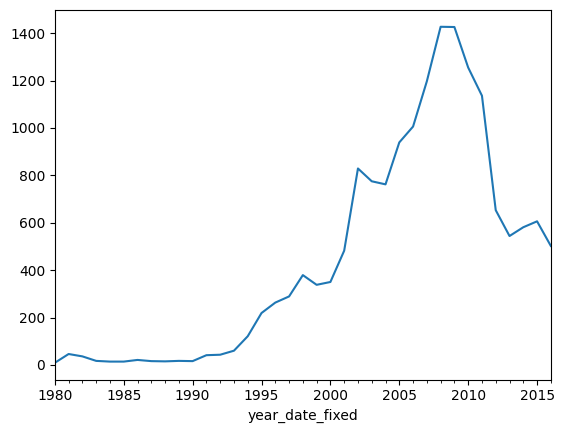

In [13]:
df_games.groupby("year_date_fixed")["name"].count().plot(kind="line")

Observamos que la industria de los videojuegos ha crecido mucho a través del tiempo. Se lanzan más videojuegos por año, aunque después de haber alcanzado su punto máximo(2009), ha bajado un poco.

Text(0.5, 1.0, 'Cantidad de videojuegos lanzados por año, sin rating (clasificación)')

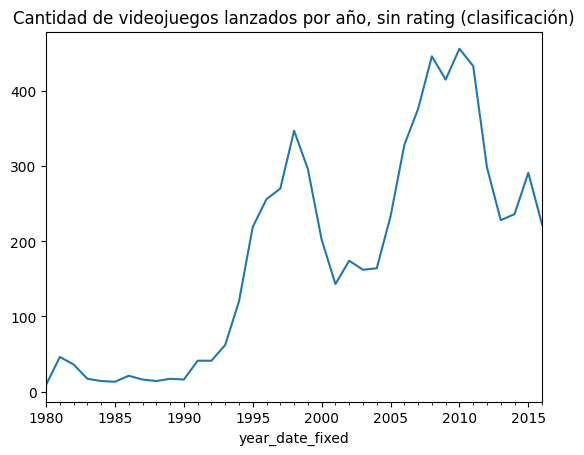

In [14]:
df_games["rating"].isna().groupby(df_games["year_date_fixed"]).sum().plot(kind="line")
plt.title("Cantidad de videojuegos lanzados por año, sin rating (clasificación)")

Quisimos explorar el número de videojuegos con valores ausentes para su "rating" (categoría de edad), pero no parece tener relación directa proporcional con el número de videojuegos que se lanzan por año.

Text(0.5, 1.0, 'Promedio de videojuegos sin rating, a través del tiempo.')

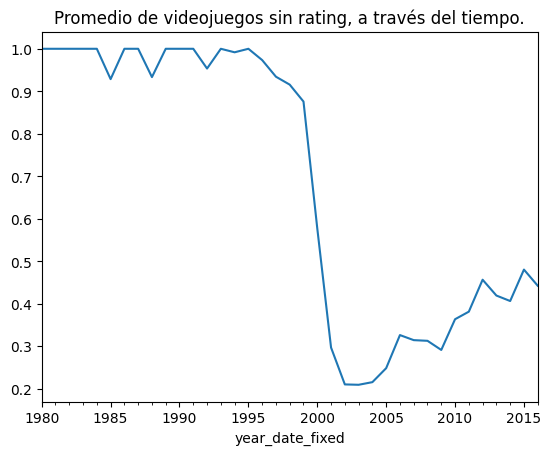

In [15]:
df_games["rating"].isna().groupby(df_games["year_date_fixed"]).mean().plot(kind="line")
plt.title("Promedio de videojuegos sin rating, a través del tiempo.")

Podemos ver en esta gráfica que el sistema de rating no existió siempre de forma obligatoria, pues antes casi todos los juegos omitian un rating. 

In [16]:
df_games.isna().sum()

name                   2
platform               0
year_of_release      269
genre                  2
na_sales               0
eu_sales               0
jp_sales               0
other_sales            0
critic_score        8578
user_score          6701
rating              6766
year_date_fixed      269
user_score_fixed    6701
dtype: int64

En name, parecen ser errores de captura de información.

En year_of_release, al ser pocos los datos ausentes, los dejaremos así.

En el caso de critic_score y user_score, los rellenaremos en función de las ventas totales.


Text(0.5, 1.0, 'Porcentaje de videojuegos sin datos en critic_score, por año.')

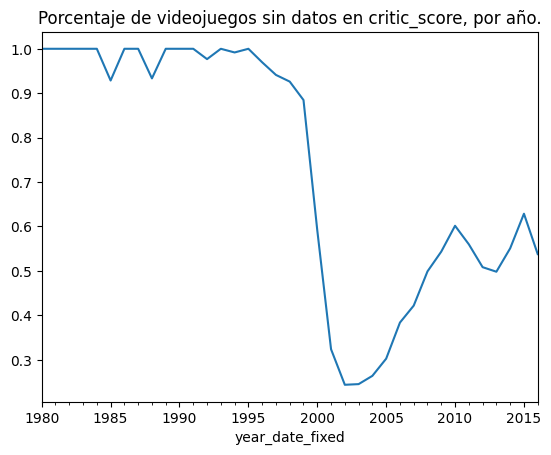

In [17]:
df_games["critic_score"].isna().groupby(df_games["year_date_fixed"]).mean().plot(kind="line")
plt.title("Porcentaje de videojuegos sin datos en critic_score, por año.")

Text(0.5, 1.0, 'Videojuegos sin datos en critic_score, por año.')

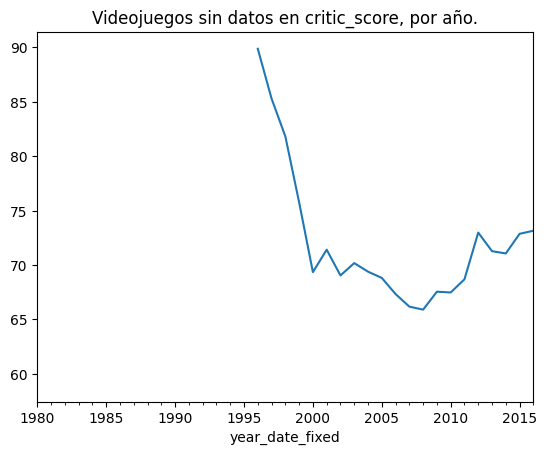

In [18]:
df_games.groupby("year_date_fixed")["critic_score"].mean().plot(kind="line")
plt.title("Videojuegos sin datos en critic_score, por año.")

Text(0.5, 1.0, 'Porcentaje de videojuegos sin datos en user_score, por año.')

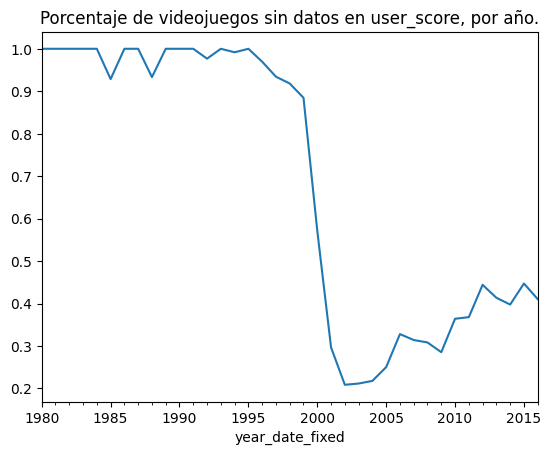

In [19]:
df_games["user_score_fixed"].isna().groupby(df_games["year_date_fixed"]).mean().plot(kind="line")
plt.title("Porcentaje de videojuegos sin datos en user_score, por año.")

Text(0.5, 1.0, 'Videojuegos sin datos en user_score, por año.')

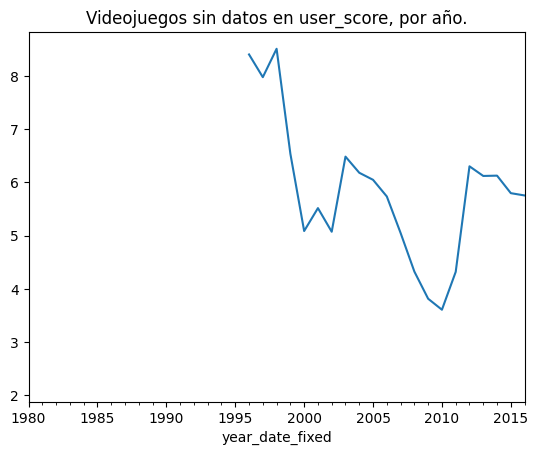

In [20]:
df_games.groupby("year_date_fixed")["user_score_fixed"].mean().plot(kind="line")
plt.title("Videojuegos sin datos en user_score, por año.")

Como podemos observar en ambos gráficos, los datos ausentes se deben en su mayoría a la falta de registros de juegos que son más viejos. Esto probablemente se deba a la falta de registro de información en ese momento.

In [21]:
filtered_games= df_games["name"][df_games["year_of_release"].isna()]

In [22]:
df_games[df_games["name"].isin(filtered_games)].sort_values(by="year_of_release")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_date_fixed,user_score_fixed
257,Sonic the Hedgehog,GEN,1991.0,Platform,3.03,0.91,0.26,0.13,NaN,NaN,NaN,1991-01-01,NaN
4264,Space Invaders,SNES,1994.0,Shooter,0.00,0.00,0.46,0.00,NaN,NaN,NaN,1994-01-01,NaN
6670,Wheel of Fortune,N64,1997.0,Misc,0.20,0.05,0.00,0.00,NaN,NaN,NaN,1997-01-01,NaN
1577,Wheel of Fortune,PS,1998.0,Misc,0.99,0.22,0.00,0.04,NaN,NaN,NaN,1998-01-01,NaN
8580,Space Invaders,N64,1999.0,Shooter,0.13,0.03,0.00,0.00,NaN,NaN,NaN,1999-01-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+,NaT,-1.0
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T,NaT,6.5
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M,NaT,6.7
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,NaT,NaN


In [23]:
df_games["total_sales"]= df_games["na_sales"] + df_games["eu_sales"] + df_games["jp_sales"] + df_games["other_sales"]

In [24]:
df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_date_fixed,user_score_fixed,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,2006-01-01,8.0,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,1985-01-01,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,2008-01-01,8.3,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,2009-01-01,8.0,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,1996-01-01,NaN,31.38


In [25]:
df_games["critic_score_fixed"] = df_games["critic_score"].astype("float")

In [26]:
# Agrupar por la suma de ventas totales y calcular la media de Critic_Score y User_Score

mean_scores = df_games.groupby('total_sales')[['critic_score_fixed', 'user_score_fixed']].mean()

In [27]:
mean_scores = mean_scores.dropna()

In [28]:
mean_scores = mean_scores.sort_values('total_sales')

In [29]:
# Creamos una función para llenar los valores ausentes
def fill_missing_scores(row):
    if row['total_sales'] in mean_scores.index:
        if pd.isnull(row['critic_score_fixed']):
            row['critic_score_fixed'] = mean_scores.loc[row['total_sales'], 'critic_score_fixed']
        if pd.isnull(row['user_score_fixed']):
            row['user_score_fixed'] = mean_scores.loc[row['total_sales'], 'user_score_fixed']
    return row

In [30]:
df_games = df_games.apply(fill_missing_scores, axis=1)

In [31]:
print(df_games.head())

                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  \
0     28.96      3.77         8.45          76.0          8      E   
1      3.58      6.81         0.77           NaN        NaN    NaN   
2     12.76      3.79         3.29          82.0        8.3      E   
3     10.93      3.28         2.95          80.0          8      E   
4      8.89     10.22         1.00           NaN        NaN    NaN   

  year_date_fixed  user_score_fixed  total_sales  critic_score_fixed  
0      2006-01-01    

In [32]:
df_games.isna().sum()

name                     2
platform                 0
year_of_release        269
genre                    2
na_sales                 0
eu_sales                 0
jp_sales                 0
other_sales              0
critic_score          8578
user_score            6701
rating                6766
year_date_fixed        269
user_score_fixed       163
total_sales              0
critic_score_fixed     184
dtype: int64

Contamos con muy pocas filas con datos ausentes, a pesar de ello, no se eliminarán, los dejaremos a un lado para nuestros análisis posteriores.

In [33]:
print(df_games[df_games["critic_score_fixed"].isna()])

                                                   name platform  \
1                                     Super Mario Bros.      NES   
4                              Pokemon Red/Pokemon Blue       GB   
5                                                Tetris       GB   
9                                             Duck Hunt      NES   
10                                           Nintendogs       DS   
...                                                 ...      ...   
4890                                        NBA Live 09      PSP   
6280                                   Guitar Hero Live      PS3   
9557                               Under Night In-Birth      PS3   
16676                                  G1 Jockey 4 2008      PS3   
16709  SCORE International Baja 1000: The Official Game      PS2   

       year_of_release         genre  na_sales  eu_sales  jp_sales  \
1               1985.0      Platform     29.08      3.58      6.81   
4               1996.0  Role-Playing     11

# Paso 3. Analiza los datos

Text(0.5, 1.0, 'Cantidad de videojuegos lanzados por año.')

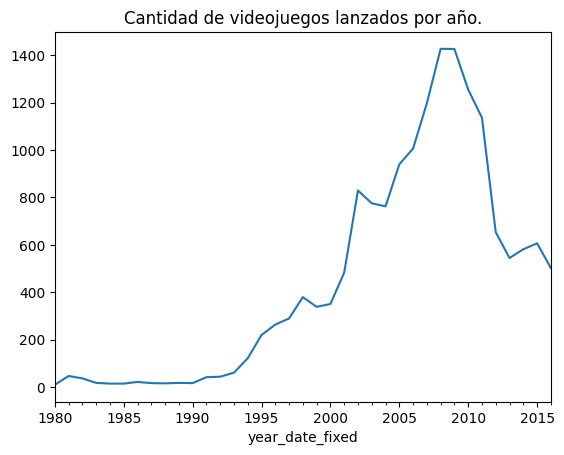

In [34]:
df_games.groupby("year_date_fixed")["name"].count().plot(kind="line")
plt.title("Cantidad de videojuegos lanzados por año.")

Vemos que antes de 1993 los juegos que se lanzaban eran pocos. Veamoslo con mayor detalle:

In [35]:
df_games.query("year_date_fixed <= '1993' ").shape

(367, 15)

In [102]:
filtered_games= df_games.query("year_date_fixed > '2004-01-01'")

filtered_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_date_fixed,user_score_fixed,total_sales,critic_score_fixed
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,2006-01-01,8.0,82.54,76.0
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,2008-01-01,8.3,35.52,82.0
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,2009-01-01,8.0,32.77,80.0
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,2006-01-01,8.5,29.80,89.0
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,2006-01-01,6.6,28.91,58.0


Solamente 367 videojuegos antes de 1993. Son muy pocos.

Text(0.5, 1.0, 'Histórico de ventas, por plataforma.')

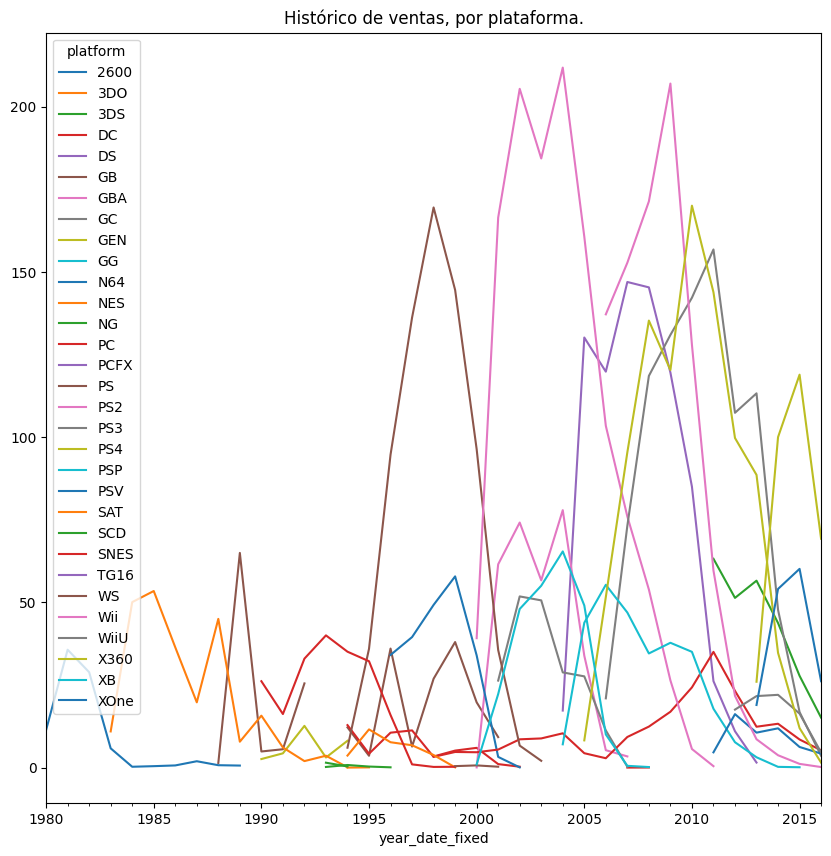

In [36]:
df_games.pivot_table(index="year_date_fixed", columns="platform", values="total_sales", aggfunc="sum").plot(kind="line", figsize=[10,10])
plt.title("Histórico de ventas, por plataforma.")

Es bueno contar con datos históricos de tantos años, sin embargo, para nuestro estudio en este proyecto, debemos seleccionar los datos de años recientes, que nos permitan predecir el comportamiento y tendencias del mercado para el año 2017. 

<AxesSubplot:xlabel='year_date_fixed'>

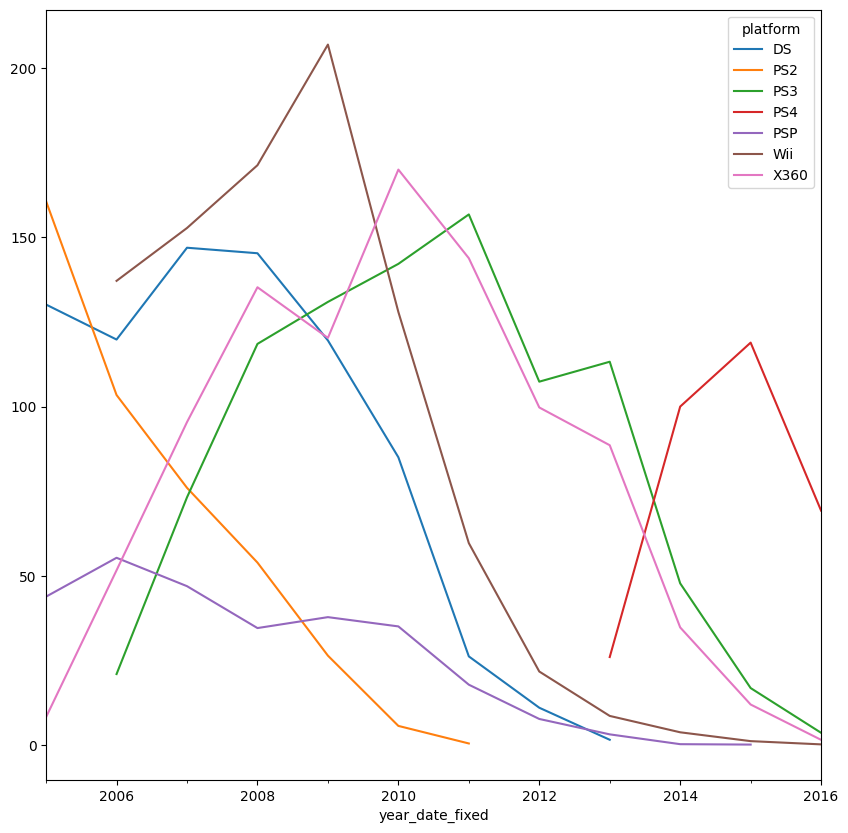

In [103]:
top_platforms= list(filtered_games.groupby("platform")["total_sales"].sum().sort_values().tail(7).index)

(
    filtered_games[filtered_games["platform"].isin(top_platforms)]
    .pivot_table(index="year_date_fixed",
                 columns="platform",
                 values="total_sales",
                 aggfunc="sum")
    .plot(kind="line",
         figsize=[10,10]
         ))


In [106]:
filtered_games= df_games.query("year_date_fixed > '2004-01-01'")

sales_by_year = filtered_games.groupby(["year_date_fixed", "platform"])["total_sales"].sum().reset_index().sort_values(by="total_sales")

print(sales_by_year)

    year_date_fixed platform  total_sales
18       2007-01-01       DC         0.02
29       2008-01-01       DC         0.04
95       2015-01-01      PSP         0.12
106      2016-01-01      Wii         0.18
37       2008-01-01       XB         0.18
..              ...      ...          ...
56       2011-01-01      PS3       156.78
4        2005-01-01      PS2       160.66
51       2010-01-01     X360       170.03
35       2008-01-01      Wii       171.32
43       2009-01-01      Wii       206.97

[110 rows x 3 columns]


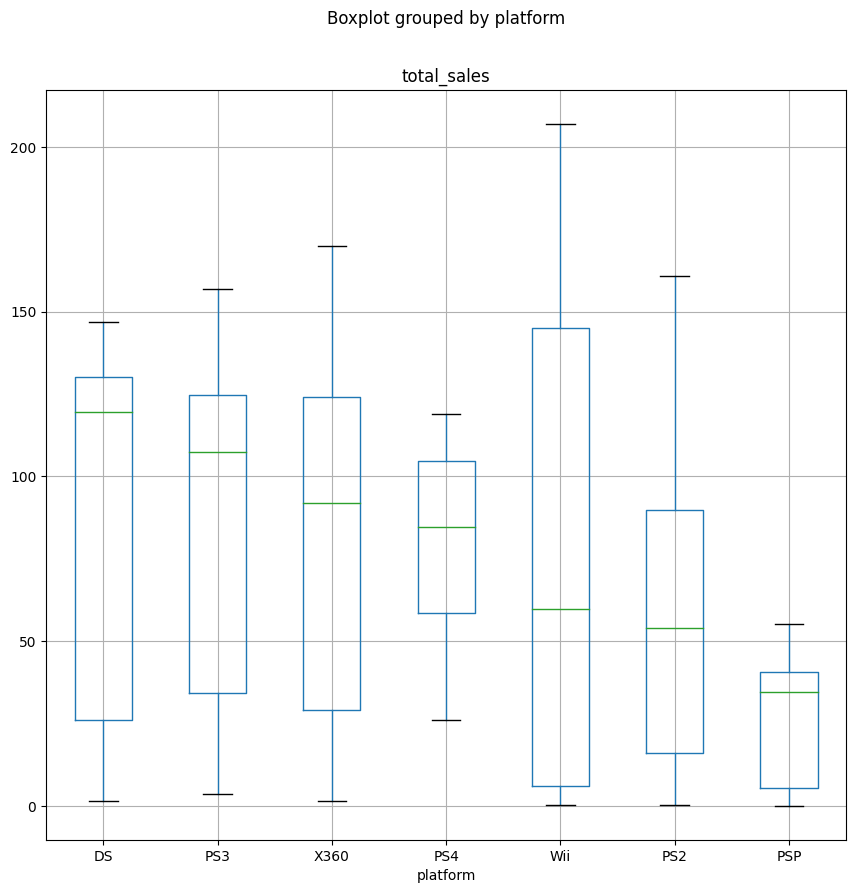

In [110]:
filtered_data = sales_by_year[sales_by_year["platform"].isin(top_platforms)].copy()

# Calcular la mediana de total_sales por plataforma
platform_medians = filtered_data.groupby('platform')['total_sales'].median().sort_values(ascending=False)

# Reordenar las plataformas en el DataFrame según la mediana de total_sales
filtered_data['platform'] = pd.Categorical(filtered_data['platform'], categories=platform_medians.index, ordered=True)

filtered_data.boxplot(column="total_sales", by="platform", figsize=[10,10])

plt.ylim()
plt.show()



In [39]:
# XBox: XB, X360, XOne

# PS: PS, PS2, PS3, PS4

# PS portátil: PSP, PSV

# Nintendo: NES, SNES, N64, GC, Wii, WiiU

# Nintendo portátil: GB, GC, GBA, DS, 3DS

Text(0.5, 1.0, 'Ciclo de vida de las nuevas plataformas de Nintendo')

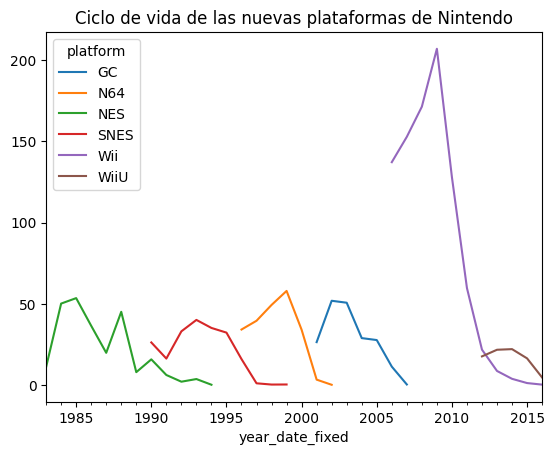

In [40]:
nintendo_to_platforms= ["NES", "SNES", "N64", "GC", "Wii", "WiiU"]

df_games[df_games["platform"].isin(nintendo_to_platforms)].pivot_table(index="year_date_fixed",
                 columns="platform",
                 values="total_sales",
                 aggfunc="sum").plot(kind="line")
plt.title("Ciclo de vida de las nuevas plataformas de Nintendo")

Apreciamos que el ciclo de vida se volvió más corto según fue tomando avances en tecnología. El ciclo de vida de sus consolas se estima al rededor de 6 años.

Text(0.5, 1.0, 'Ciclo de vida de las nuevas plataformas de PlayStation')

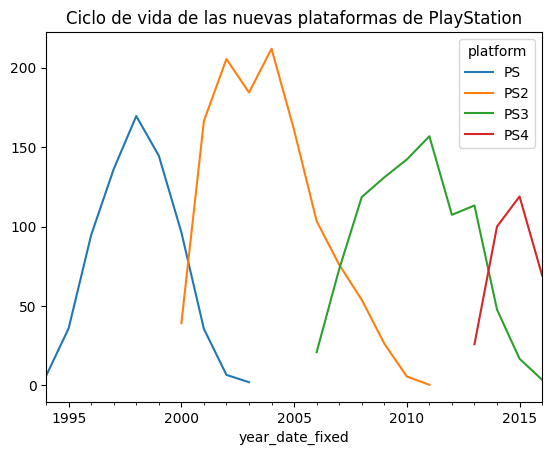

In [41]:
ps_to_platforms= ["PS", "PS2", "PS3", "PS4"]

df_games[df_games["platform"].isin(ps_to_platforms)].pivot_table(index="year_date_fixed",
                 columns="platform",
                 values="total_sales",
                 aggfunc="sum").plot(kind="line")
plt.title("Ciclo de vida de las nuevas plataformas de PlayStation")

Apreciamos que el ciclo de vida se volvió más amplio en comparación con PS (sony). Para las plataformas de Sony tienen un estimado de entre 9 y 11 años.

Text(0.5, 1.0, 'Ciclo de vida de las nuevas plataformas de Microsoft')

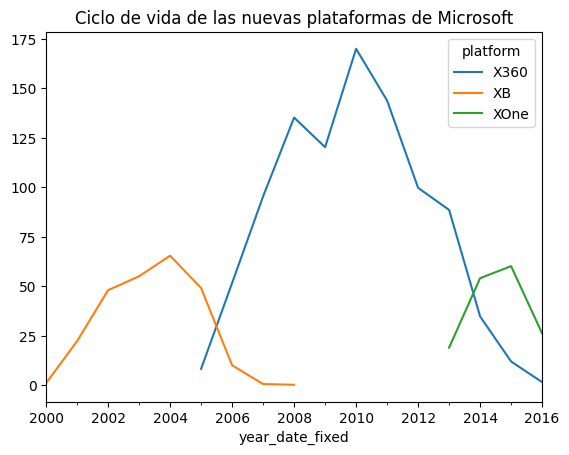

In [42]:
microsoft_to_platforms= ["XB", "X360", "XOne"]

df_games[df_games["platform"].isin(microsoft_to_platforms)].pivot_table(index="year_date_fixed",
                 columns="platform",
                 values="total_sales",
                 aggfunc="sum").plot(kind="line")
plt.title("Ciclo de vida de las nuevas plataformas de Microsoft")

Apreciamos que el ciclo de vida se volvió más amplio en comparación con nintendo. Para las plataformas de Sony tienen un estimado de entre 8 y 14 años.

In [43]:
df_games.groupby("platform")["year_date_fixed"].nunique().sort_values(ascending=False)

platform
PC      26
GB      13
NES     12
X360    12
PSP     12
PS2     12
Wii     11
DS      11
PS3     11
2600    10
SNES    10
PS      10
XB       9
GBA      8
DC       7
GC       7
N64      7
SAT      6
3DS      6
PSV      6
WiiU     5
GEN      5
NG       4
PS4      4
XOne     4
WS       3
SCD      2
3DO      2
TG16     1
GG       1
PCFX     1
Name: year_date_fixed, dtype: int64

Observamos que "PC" es la plataforma más longeva de todas. Siendo relevante en la actualidad.


Text(0.5, 1.0, 'Histórico de ventas, por plataforma.')

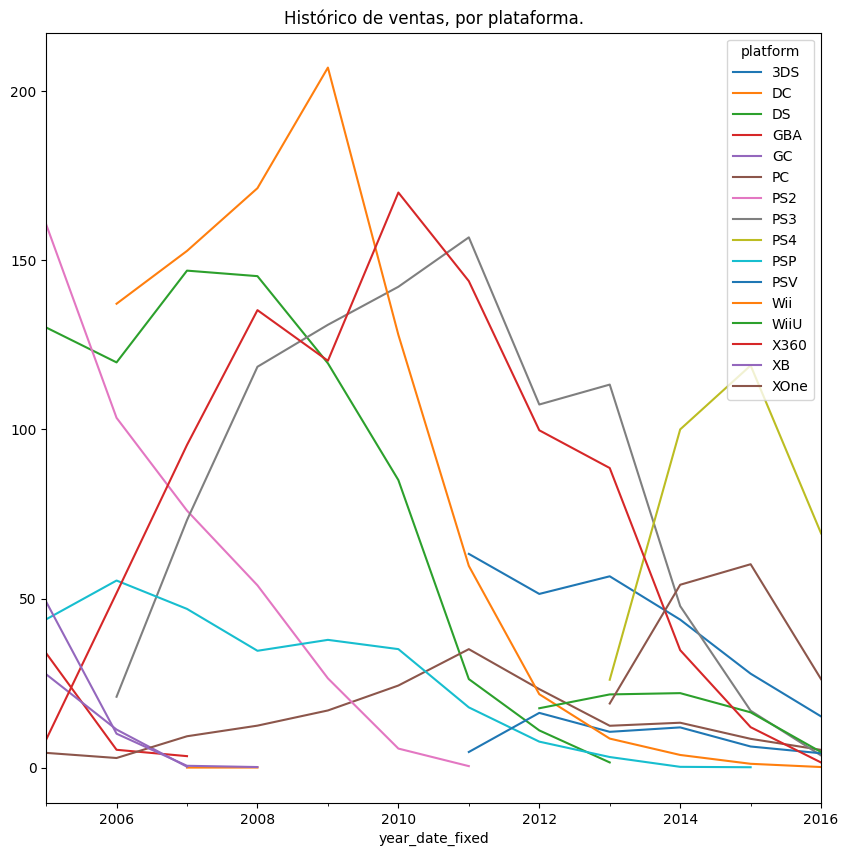

In [111]:
filtered_games.pivot_table(index="year_date_fixed", columns="platform", values="total_sales", aggfunc="sum").plot(kind="line", figsize=[10,10])
plt.title("Histórico de ventas, por plataforma.")

Gracias a este gráfico podemos concluir que los datos más representativos para hacer una predicción en nuestros datos y construir un modelo útil para el 2017, los datos deberían ser lo más cercanos al 2017, tomaremos la infromación disponible a partir del año 2004.

In [116]:
df_games= df_games[df_games["year_date_fixed"]>= "2004-01-01"]

<AxesSubplot:xlabel='year_date_fixed'>

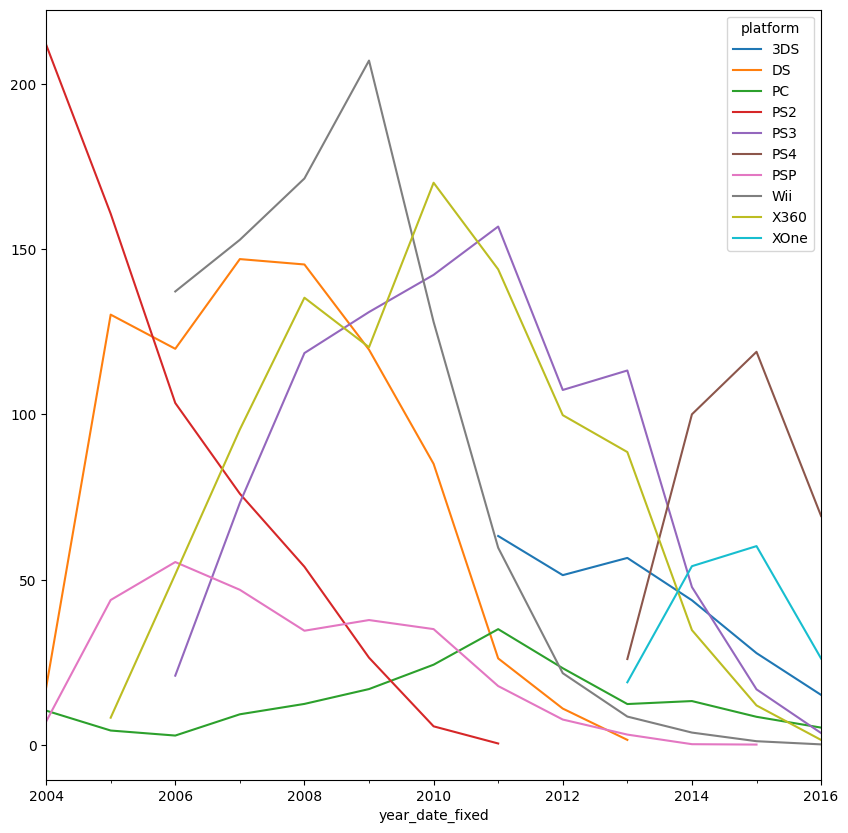

In [117]:
top_platforms= list(df_games.groupby("platform")["total_sales"].sum().sort_values().tail(10).index)

(
    df_games[df_games["platform"].isin(top_platforms)]
    .pivot_table(index="year_date_fixed",
                 columns="platform",
                 values="total_sales",
                 aggfunc="sum")
    .plot(kind="line",
         figsize=[10,10]
         ))


Las plataformas potencialmente rentables, son principalmente aquellas de "Sony", "Microsoft", "Nintendo" y la "PC".

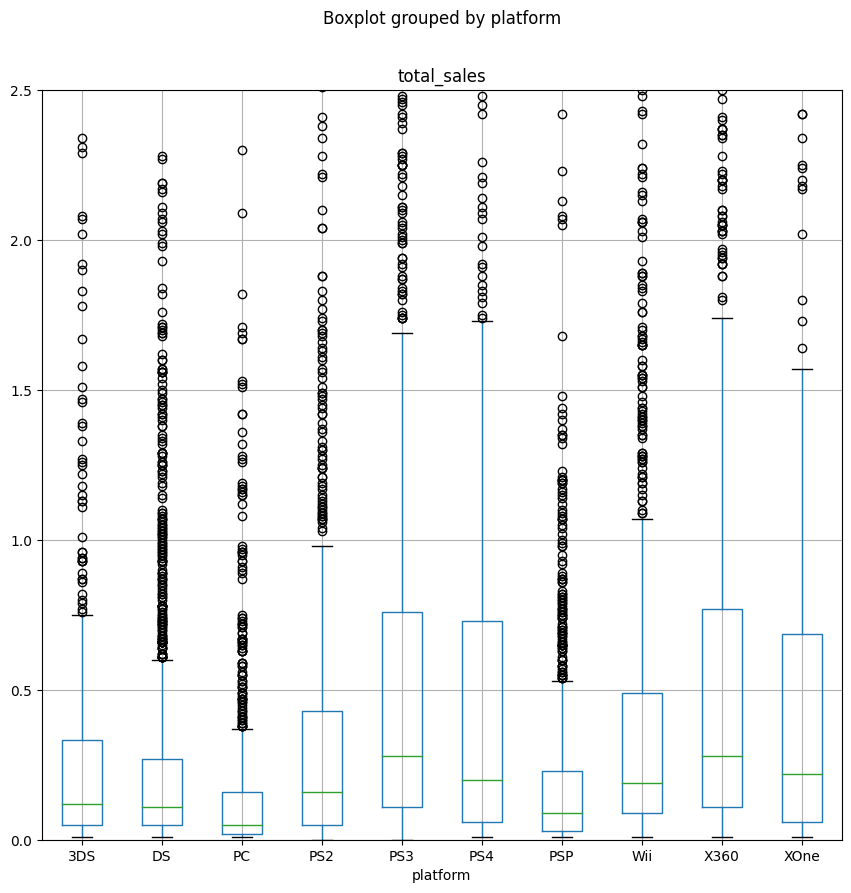

In [118]:
filtered_games[filtered_games["platform"].isin(top_platforms)].boxplot(
    column="total_sales",
    by="platform",
    figsize=[10,10]
)
plt.ylim(0, 2.5)
plt.show()

Las diferencias de ventas son significativas: Tenemos 6 plataformas con ventas mayores:  "PS2", "PS3", "PS4", "X360", "XOne" y "Wii".

Text(0.5, 1.0, 'Promedio de ventas de videojuegos por plataforma.')

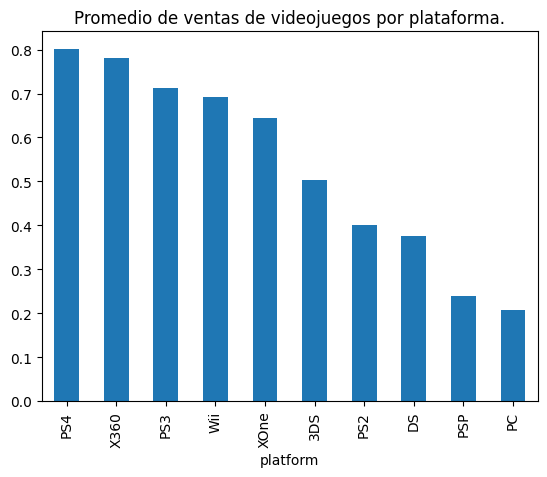

In [119]:
filtered_games[filtered_games["platform"].isin(top_platforms)].groupby("platform")["total_sales"].mean().sort_values(ascending=False).plot(kind="bar")

plt.title("Promedio de ventas de videojuegos por plataforma.")

Observamos en la gráfica que si son significativas las diferencias de ventas por plataforma. Después de nuestras 5 principales consolas, existe un salto considerable. Se aprecia a simple vista.

Un videojuego en PS4 vende más que un videojuego en X360 o PS3.

Text(0, 0.5, 'Total Sales')

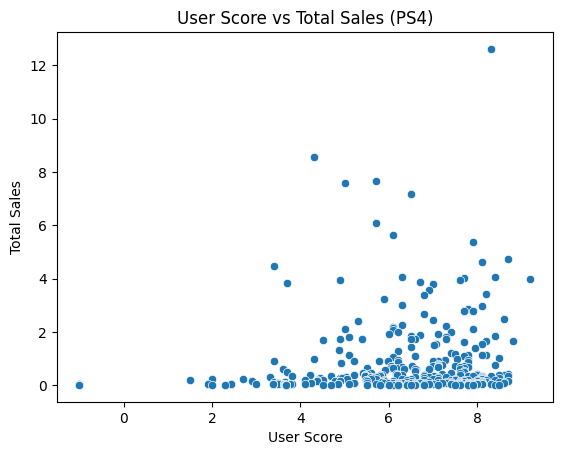

In [120]:
df_ps4 = df_games[df_games["platform"] == "PS4"]

sns.scatterplot(x="user_score_fixed", y="total_sales", data=df_ps4)

plt.title("User Score vs Total Sales (PS4)")
plt.xlabel("User Score")
plt.ylabel("Total Sales")

Text(0, 0.5, 'Total Sales')

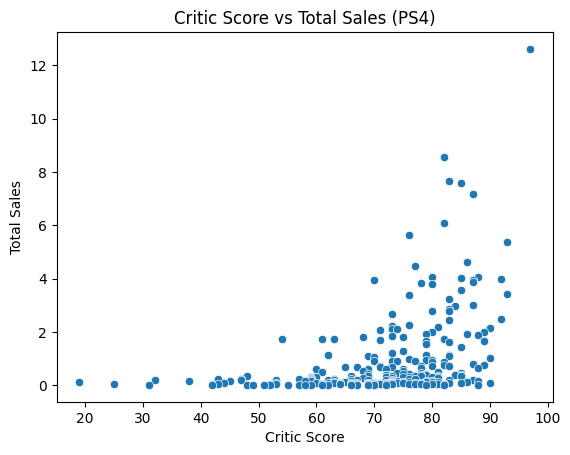

In [121]:
sns.scatterplot(x="critic_score", y="total_sales", data=df_ps4)
plt.title("Critic Score vs Total Sales (PS4)")
plt.xlabel("Critic Score")
plt.ylabel("Total Sales")

In [122]:
filtered_games.query("platform =='PS4'")[["total_sales", "user_score_fixed"]].corr()



,total_sales,user_score_fixed
total_sales,1.000000,0.177523
user_score_fixed,0.177523,1.000000


Nuestro cálculo de correlación pudiera no ser el más preciso debido a que nuestra columna sufrió un tratamiento de datos (añadimos -1 en los datos ausentes). Nos fiaremos principalmente en la correlación con los datos de "critic_score".

In [123]:
filtered_games.query("platform =='PS4'")[["total_sales", "critic_score"]].corr()


,total_sales,critic_score
total_sales,1.000000,0.406568
critic_score,0.406568,1.000000


Se calcularon las correlaciones entre el total de ventas de los videojuegos vendidos para PS4, "critic_score" y "user_score".

La correlación comienza a ser importante entre "critic_score" y "total_sales".

In [124]:
#df_games.groupby("name")["platform"].nunique().sort_values(ascending=False)

In [125]:
ps4_games = df_ps4["name"].unique()

df_other_platforms = df_games[df_games["name"].isin(ps4_games) & (df_games["platform"] != "PS4")]

In [126]:
user_corr_other = df_other_platforms[["total_sales", "user_score_fixed"]].corr()

critic_corr_other=df_other_platforms[["total_sales", "critic_score"]].corr()

In [127]:
print(f"Correlación entre user score y total sales en otras plataformas: {user_corr_other}")
print(f"Correlación entre critic score y total sales en otras plataformas: {critic_corr_other}")

Correlación entre user score y total sales en otras plataformas:                   total_sales  user_score_fixed
total_sales          1.000000          0.111121
user_score_fixed     0.111121          1.000000
Correlación entre critic score y total sales en otras plataformas:               total_sales  critic_score
total_sales      1.000000      0.306539
critic_score     0.306539      1.000000


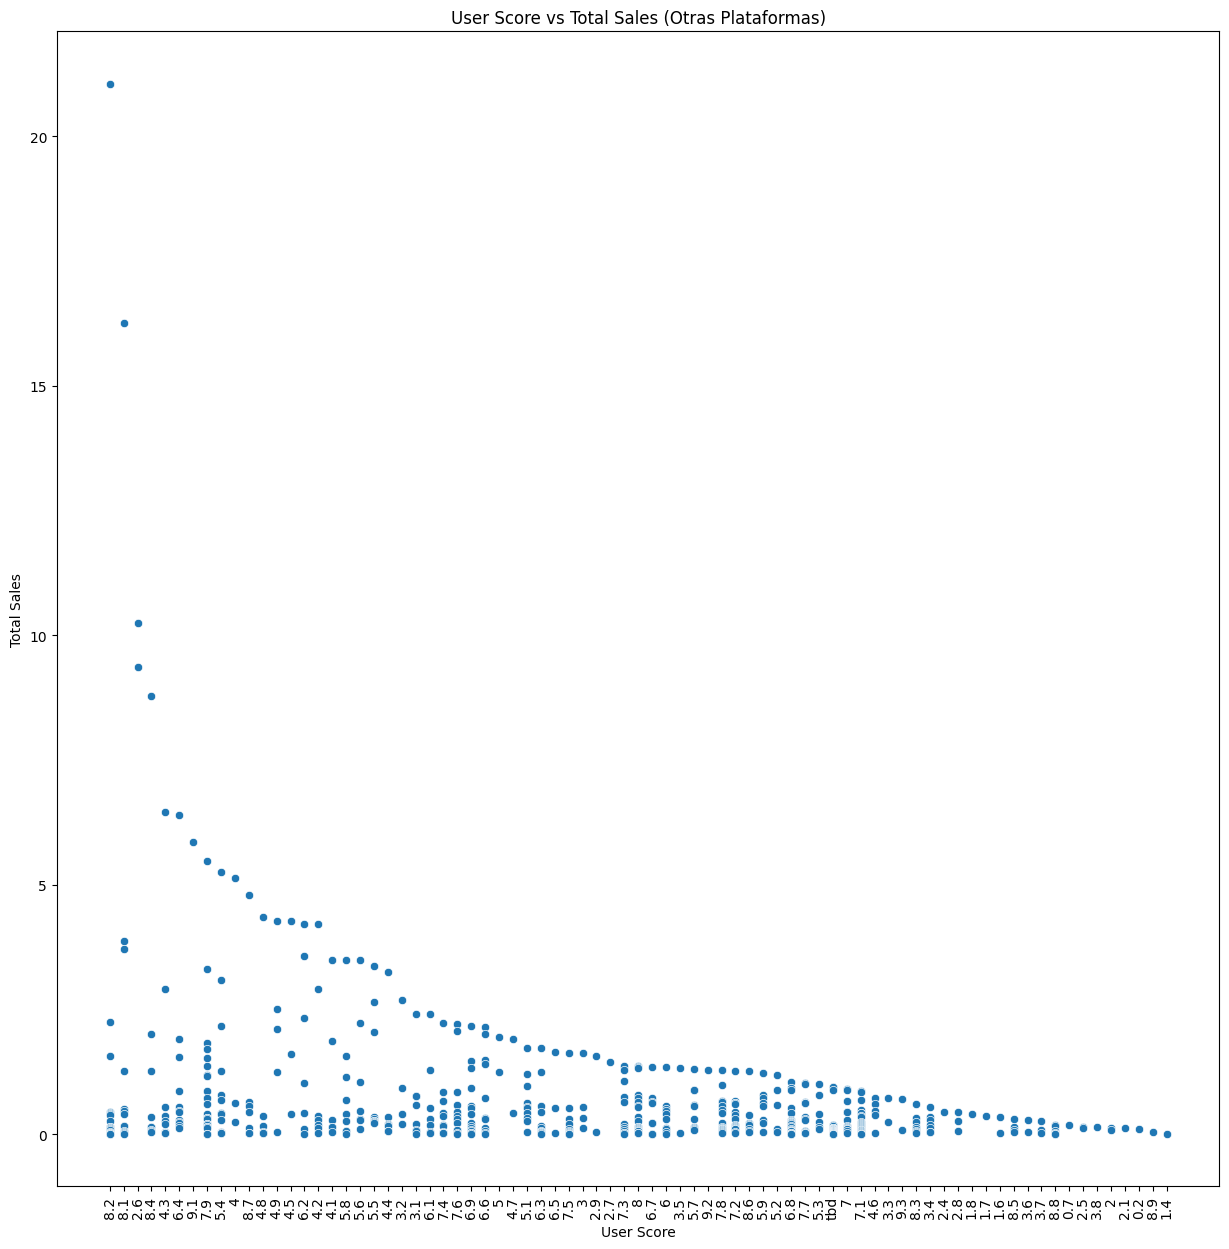

In [128]:
plt.figure(figsize=(15, 15))
sns.scatterplot(x="user_score", y="total_sales", data=df_other_platforms)
plt.title("User Score vs Total Sales (Otras Plataformas)")
plt.xlabel("User Score")
plt.ylabel("Total Sales")
plt.xticks(rotation=90)
plt.show()

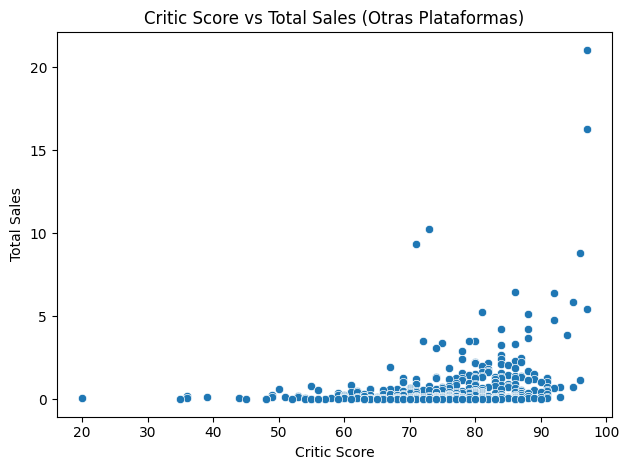

In [129]:
sns.scatterplot(x="critic_score", y="total_sales", data=df_other_platforms)
plt.title("Critic Score vs Total Sales (Otras Plataformas)")
plt.xlabel("Critic Score")
plt.ylabel("Total Sales")

plt.tight_layout()
plt.show()

Podemos observar que existe una fuerte relación entre altas ventas de videojuegos y altas calificaciones tanto en "critic_score" y "user_score"

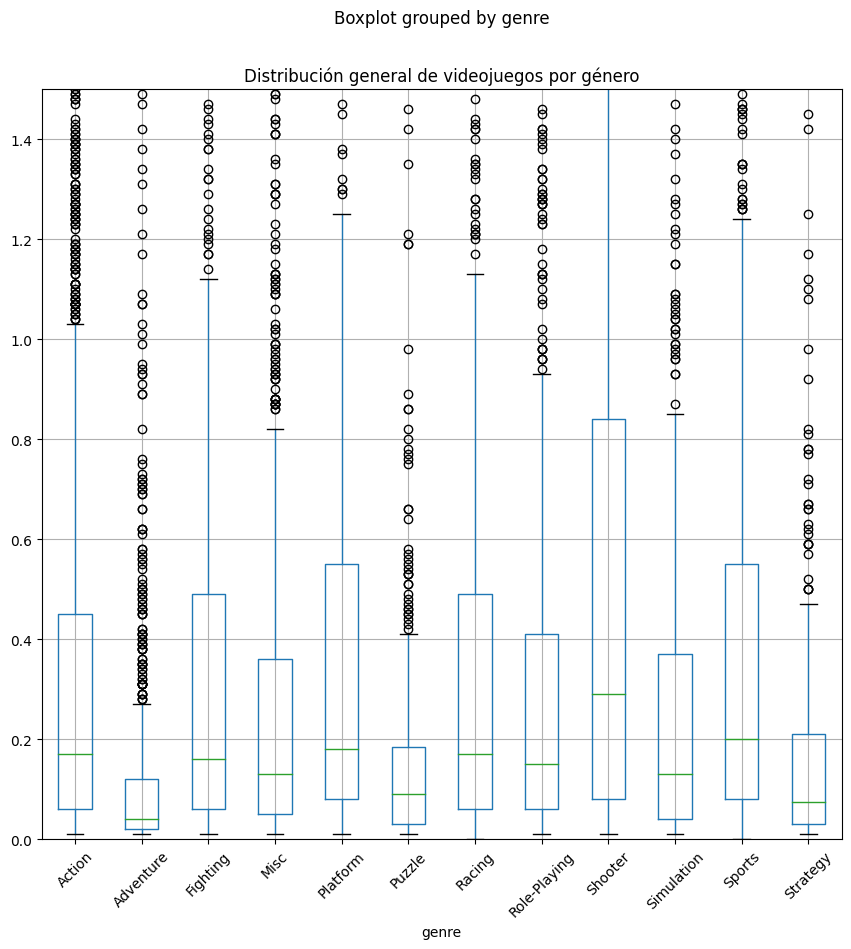

In [130]:
filtered_games.boxplot(
    column="total_sales",
    by="genre",
    figsize=[10,10]
)
plt.ylim(0, 1.5)
plt.xticks(rotation=45)
plt.title("Distribución general de videojuegos por género")
plt.show()

Podemos concluir gracias a este gráfico que los videojuegos de "shooter", "platform", "sports", "Fighting", "Action", "Racing" y "Role-Playing" son mejores géneros en general. Debido a que tienen una media de venta superior en comparación con juegos de estrategia (por ejemplo).

# Paso 4. Crea un perfil de usuario para cada región.

In [131]:
print(df_games.head())

                    name platform  year_of_release     genre  na_sales  \
0             Wii Sports      Wii           2006.0    Sports     41.36   
2         Mario Kart Wii      Wii           2008.0    Racing     15.68   
3      Wii Sports Resort      Wii           2009.0    Sports     15.61   
6  New Super Mario Bros.       DS           2006.0  Platform     11.28   
7               Wii Play      Wii           2006.0      Misc     13.96   

   eu_sales  jp_sales  other_sales  critic_score user_score rating  \
0     28.96      3.77         8.45          76.0          8      E   
2     12.76      3.79         3.29          82.0        8.3      E   
3     10.93      3.28         2.95          80.0          8      E   
6      9.14      6.50         2.88          89.0        8.5      E   
7      9.18      2.93         2.84          58.0        6.6      E   

  year_date_fixed  user_score_fixed  total_sales  critic_score_fixed  
0      2006-01-01               8.0        82.54               

In [132]:
# Crear un DataFrame separado para cada región
df_na = df_games[['platform', 'genre', 'na_sales', 'rating']]
df_eu = df_games[['platform', 'genre', 'eu_sales', 'rating']]
df_jp = df_games[['platform', 'genre', 'jp_sales', 'rating']]

In [133]:
# Renombrar las columnas de ventas para cada región
df_na = df_na.rename(columns={'na_sales': 'sales'})
df_eu = df_eu.rename(columns={'eu_sales': 'sales'})
df_jp = df_jp.rename(columns={'jp_sales': 'sales'})

In [134]:
# Función para obtener las cinco plataformas principales por región
def top_platforms(df, region_name):
    platforms = df.groupby('platform')['sales'].sum().sort_values(ascending=False).head(5)
    return platforms

In [135]:
top_platforms_na = top_platforms(df_na, 'NA')
top_platforms_eu = top_platforms(df_eu, 'EU')
top_platforms_jp = top_platforms(df_jp, 'JP')

print("Top 5 platforms in NA:\n", top_platforms_na)
print("Top 5 platforms in EU:\n", top_platforms_eu)
print("Top 5 platforms in JP:\n", top_platforms_jp)

Top 5 platforms in NA:
 platform
X360    595.74
Wii     486.87
PS3     390.13
DS      380.31
PS2     297.27
Name: sales, dtype: float64
Top 5 platforms in EU:
 platform
PS3     327.21
X360    268.32
Wii     258.32
DS      188.41
PS2     143.15
Name: sales, dtype: float64
Top 5 platforms in JP:
 platform
DS     175.00
3DS    100.62
PS3     79.41
PSP     75.88
PS2     70.15
Name: sales, dtype: float64


Plataformas Principales:

NA: Las plataformas más populares en NA podrían incluir X360, PS2, Wii, PS3, DS.

EU: Las plataformas principales en EU son un poco similares a NA, pero con diferencias en la cuota de mercado y PS en lugar de DS.

JP: En Japón, las plataformas más populares tienden a ser diferentes, con Nintendo y Sony dominando el mercado.

In [136]:
# Función para obtener los cinco géneros principales por región
def top_genres(df, region_name):
    genres = df.groupby('genre')['sales'].sum().sort_values(ascending=False).head(5)
    return genres

In [137]:
top_genres_na = top_genres(df_na, 'NA')
top_genres_eu = top_genres(df_eu, 'EU')
top_genres_jp = top_genres(df_jp, 'JP')

print("Top 5 genres in NA:\n", top_genres_na)
print("Top 5 genres in EU:\n", top_genres_eu)
print("Top 5 genres in JP:\n", top_genres_jp)

Top 5 genres in NA:
 genre
Action          619.12
Sports          471.22
Shooter         431.30
Misc            328.97
Role-Playing    233.41
Name: sales, dtype: float64
Top 5 genres in EU:
 genre
Action     388.60
Sports     280.47
Shooter    260.83
Misc       176.53
Racing     141.51
Name: sales, dtype: float64
Top 5 genres in JP:
 genre
Role-Playing    193.09
Action          113.21
Misc             74.92
Sports           56.93
Platform         42.43
Name: sales, dtype: float64


Géneros Principales:

NA: Géneros como Acción, Deportes, Disparos,   suelen ser populares.

EU: Los géneros pueden ser similares a NA, pero con la diferencia que se agrega Racing y quitamos Misc.

JP: En Japón, los géneros como RPG(Role-Playing-Game) y Acción son predominantemente populares, también incluimos Deportes, Plataforma y Misc(género mixto).


In [138]:
# Función para analizar el impacto de las clasificaciones ESRB en las ventas por región
def esrb_rating_impact(df, region_name):
    esrb_rating = df.groupby('rating')['sales'].sum().sort_values(ascending=False)
    return esrb_rating

In [139]:
esrb_impact_na = esrb_rating_impact(df_na, 'NA')
esrb_impact_eu = esrb_rating_impact(df_eu, 'EU')
esrb_impact_jp = esrb_rating_impact(df_jp, 'JP')

print("ESRB rating impact in NA:\n", esrb_impact_na)
print("ESRB rating impact in EU:\n", esrb_impact_eu)
print("ESRB rating impact in JP:\n", esrb_impact_jp)

ESRB rating impact in NA:
 rating
E       970.77
M       649.34
T       527.80
E10+    345.24
EC        1.53
AO        1.26
RP        0.00
Name: sales, dtype: float64
ESRB rating impact in EU:
 rating
E       549.81
M       428.59
T       291.23
E10+    183.23
AO        0.61
EC        0.11
RP        0.03
Name: sales, dtype: float64
ESRB rating impact in JP:
 rating
E       159.27
T        99.28
M        48.55
E10+     40.03
AO        0.00
EC        0.00
RP        0.00
Name: sales, dtype: float64


Impacto de las Clasificaciones ESRB:

NA y EU: Las clasificaciones como "M" (Mature) y "E" (Everyone) pueden tener un impacto significativo en las ventas.

JP: Las clasificaciones de ESRB pueden tener un impacto menor, ya que Japón tiene su propio sistema de clasificación (CERO).

# Paso 5. Pruebas de hipótesis:

In [140]:
df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_date_fixed,user_score_fixed,total_sales,critic_score_fixed
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,2006-01-01,8.0,82.54,76.0
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,2008-01-01,8.3,35.52,82.0
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,2009-01-01,8.0,32.77,80.0
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,2006-01-01,8.5,29.80,89.0
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,2006-01-01,6.6,28.91,58.0


In [141]:
df_games_notnull = df_games[df_games['user_score_fixed'].notnull()]
alpha = 0.05

Hipótesis sobre las plataformas Xbox One y PC:

Hipótesis nula (H0): Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son iguales.
    
Hipótesis alternativa (H1): Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.

In [142]:
# Filtrar los datos por plataforma
xbox_one_scores = df_games_notnull[df_games_notnull['platform'] == 'XOne']['user_score_fixed']
pc_scores = df_games_notnull[df_games_notnull['platform'] == 'PC']['user_score_fixed']


# Realizar la prueba t de Student para plataformas
t_stat_platforms, p_val_platforms = st.ttest_ind(xbox_one_scores, pc_scores, equal_var=False)

print("Plataformas: Xbox One vs. PC")
print(f"T-statistic: {t_stat_platforms}, P-value: {p_val_platforms}")
if p_val_platforms < alpha:
    print("Se rechaza la hipótesis nula: las calificaciones promedio de los usuarios son diferentes.")
else:
    print("No se rechaza la hipótesis nula: las calificaciones promedio de los usuarios son iguales.")


Plataformas: Xbox One vs. PC
T-statistic: -1.4409004127441116, P-value: 0.15030145765390548
No se rechaza la hipótesis nula: las calificaciones promedio de los usuarios son iguales.


In [143]:
print(xbox_one_scores.mean())
print(pc_scores.mean())

5.823563235742507
6.050786618240924


Hipótesis sobre los géneros Acción y Deportes:

Hipótesis nula (H0): Las calificaciones promedio de los usuarios para los géneros Acción y Deportes son iguales.
    
Hipótesis alternativa (H1): Las calificaciones promedio de los usuarios para los géneros Acción y Deportes son diferentes.

In [144]:
# Filtrar los datos por género
action_scores = df_games_notnull[df_games_notnull['genre'] == 'Action']['user_score_fixed']
sports_scores = df_games_notnull[df_games_notnull['genre'] == 'Sports']['user_score_fixed']


# Realizar la prueba t de Student para géneros
t_stat_genres, p_val_genres = st.ttest_ind(action_scores, sports_scores, equal_var=False)


print("Géneros: Acción vs. Deportes")
print(f"T-statistic: {t_stat_genres}, P-value: {p_val_genres}")
if p_val_genres < alpha:
    print("Se rechaza la hipótesis nula: las calificaciones promedio de los usuarios son diferentes.")
else:
    print("No se rechaza la hipótesis nula: las calificaciones promedio de los usuarios son iguales.")

Géneros: Acción vs. Deportes
T-statistic: 5.909468598468438, P-value: 3.857763090311147e-09
Se rechaza la hipótesis nula: las calificaciones promedio de los usuarios son diferentes.


In [145]:
print(action_scores.mean())
print(sports_scores.mean())

5.230571238499579
4.639674557414881


Para ambas hipótesis, utilizamos la prueba t de Student para muestras independientes (ttest_ind). Este test es adecuado para comparar las medias de dos grupos independientes. 

# Paso 6. Escribe una conclusión general

Durante este análisis, hemos llevado a cabo varios pasos para entender mejor los datos y obtener información relevante sobre las ventas y las calificaciones de videojuegos en diferentes plataformas y géneros.

Cargamos y preparamos los datos, asegurándonos de manejar adecuadamente los valores nulos y renombrando las columnas a minúsculas para facilitar su manipulación.

Calculamos las ventas totales de videojuegos sumando las ventas en todas las regiones y creando una columna separada para estos valores.

Creamos gráficos de dispersión para analizar la relación entre las calificaciones de los usuarios y las ventas totales de videojuegos en diferentes plataformas.

Observamos que las calificaciones de los usuarios tienen una correlación positiva con las ventas en ciertas plataformas populares, lo que sugiere que las buenas calificaciones pueden estar asociadas con mayores ventas.

Comparamos las ventas de los mismos videojuegos en diferentes plataformas. Notamos que algunos juegos tienen mejores ventas en ciertas plataformas, lo que podría estar influenciado por factores como la popularidad de la plataforma, el tipo de juego y la base de usuarios.

Los desarrolladores y editores pueden utilizar estos hallazgos para optimizar el lanzamiento de juegos en plataformas específicas (XOne, PS4, WiiU y me atrevería a incluir la PC) y centrarse en los géneros más populares por región (Acción, Deportes, Shooters y Role-Playing).

En resumen, este análisis proporciona una visión integral de cómo diversos factores afectan las ventas de videojuegos y cómo las preferencias de los usuarios varían entre diferentes plataformas y regiones.